# Stock Market Trend Prediciton using Random Forest (e.g S&P500)

In [233]:
import yfinance as yf 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [234]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = 'max')
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


<Axes: xlabel='Date'>

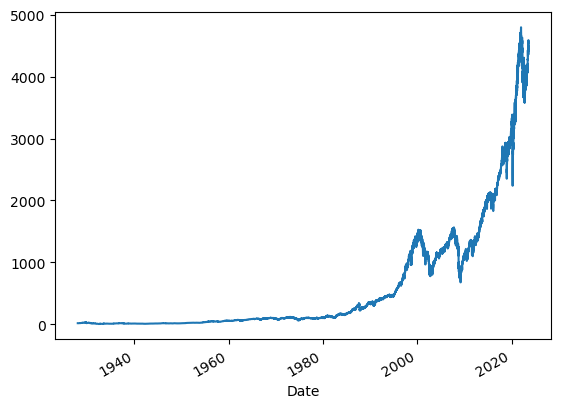

In [235]:
sp500['Close'].plot(kind = 'line')

In [236]:
sp500 = sp500.drop(columns = ['Dividends', 'Stock Splits'])
sp500.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0


In [237]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int) 
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0


In [238]:
sp500 = sp500.loc['1990-01-01':].copy()
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [239]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [240]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.546875

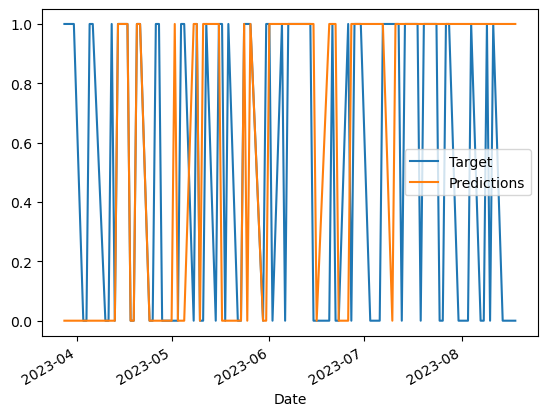

In [241]:
test['Target'].plot(kind = 'line')
preds.plot(kind = 'line')
plt.legend(['Target', 'Predictions'], loc = 'right')

In [242]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [243]:
predictions = backtest(sp500, model, predictors)
predictions.head()

,Target,Predictions
Date,,
1999-11-22 00:00:00-05:00,0,0
1999-11-23 00:00:00-05:00,1,0
1999-11-24 00:00:00-05:00,0,0
1999-11-26 00:00:00-05:00,0,0
1999-11-29 00:00:00-05:00,0,0


In [244]:
precision_score(predictions["Target"], predictions['Predictions'])

0.528740157480315

# Improvements on Random Forest predictions using rolling mean

In [245]:
horizons = [2, 5, 60, 250, 1000] # 60 is about 3 months, 250 is last year, 1000 is last 4 years
new_predictors = []

for x in horizons: 
    rolling_avg = sp500.rolling(x).mean()

    ratio_column = f'Close ratio {x}'
    sp500[ratio_column] = sp500['Close'] / rolling_avg['Close']

    trend_column = f'Trend over {x}'
    sp500[trend_column] = sp500.shift(1).rolling(x).sum()['Target']

    new_predictors += [ratio_column, trend_column]

In [246]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close ratio 2,Trend over 2,Close ratio 5,Trend over 5,Close ratio 60,Trend over 60,Close ratio 250,Trend over 250,Close ratio 1000,Trend over 1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-14 00:00:00-04:00,4458.129883,4490.330078,4453.439941,4489.720215,3896410000,4437.859863,0,1.002867,1.0,1.002631,2.0,1.020476,34.0,1.103469,120.0,1.169828,534.0
2023-08-15 00:00:00-04:00,4478.870117,4478.870117,4432.189941,4437.859863,3832250000,4404.330078,0,0.994191,1.0,0.993780,2.0,1.007773,33.0,1.090581,119.0,1.155837,534.0
2023-08-16 00:00:00-04:00,4433.790039,4449.950195,4403.549805,4404.330078,3753910000,4370.359863,0,0.996208,0.0,0.989080,2.0,0.999356,33.0,1.082203,119.0,1.146648,533.0


In [247]:
sp500 = sp500.dropna()

In [248]:
model = RandomForestClassifier(n_estimators=200, min_samples_split = 50, random_state = 1) 


In [249]:
# we change our predict function to use probability

def predict_prob(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] # getting the second column which is just the probability of price go up
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest_prob(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_prob(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [250]:
predictions = backtest_prob(sp500, model, new_predictors)


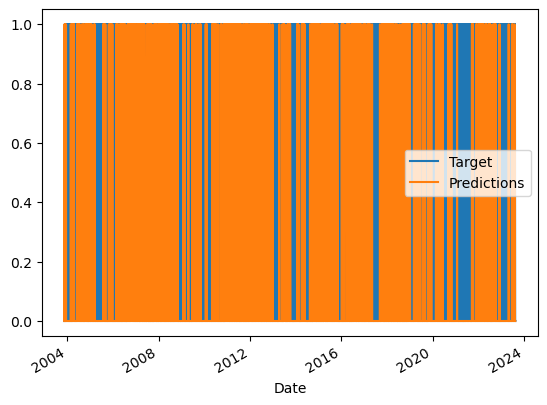

In [251]:
predictions['Target'].plot(kind = 'line')
predictions['Predictions'].plot(kind = 'line') 
plt.legend(['Target', 'Predictions'], loc = 'right') 

In [252]:
precision_score(predictions["Target"], predictions["Predictions"])

0.568986568986569

Improvements on Random Forest predictions using directional tracker instead of rolling to predict trend and prices.

In [253]:
# Redefining sp500 
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = 'max')
sp500 = sp500.drop(columns = ['Dividends', 'Stock Splits'])
sp500.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0


In [254]:
# Creating target for trends 
sp500['Target'] = (sp500['Close'].shift(-1) > sp500['Close']).astype(int) 

# creating mean rolling for 2, 5, 60, 250, 1000
horizons = [2, 5, 60, 250, 1000]

for x in horizons:
    sp500[f'MR{x}'] = sp500['Close'].rolling(x).mean()
    sp500[f'MRD{x}'] = sp500['Close'] - sp500[f'MR{x}']

sp500.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000
Date,,,,,,,,,,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0,17.710000,0.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0,17.740000,-0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,1,17.634999,-0.085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0,17.605000,0.055,17.67,-0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
# dropping NA entries 
sp500 = sp500.dropna()

In [256]:
# defining model
model = RandomForestClassifier(n_estimators=200, min_samples_split = 50, random_state = 1) 

In [257]:
# slight modification to the previous prob predict and backtest functions
def predict_prob(train, test, predictors, target, model):
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1] # getting the second column which is just the probability of price go up
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

def backtest_prob(data, model, predictors, target, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_prob(train, test, predictors, target, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [258]:
predictors = [f'MRD{x}' for x in horizons]
target_predictions = backtest_prob(sp500, model, predictors, 'Target')

In [259]:
precision_score(predictions["Target"], predictions['Predictions'])

0.568986568986569

# Price predictions using Support Vector Regression (SVR)

In [260]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
1931-12-28 00:00:00-05:00,7.760000,7.760000,7.760000,7.760000,0,1,7.860000,-0.100000,8.022000,-0.262000,9.721333,-1.961333,13.704760,-5.944760,20.197110,-12.437110,7.960000
1931-12-29 00:00:00-05:00,7.960000,7.960000,7.960000,7.960000,0,1,7.860000,0.100000,7.984000,-0.024000,9.692167,-1.732167,13.675240,-5.715240,20.187410,-12.227410,8.100000
1931-12-30 00:00:00-05:00,8.100000,8.100000,8.100000,8.100000,0,1,8.030000,0.070000,7.946000,0.154000,9.668333,-1.568333,13.644240,-5.544240,20.177750,-12.077750,8.120000
1931-12-31 00:00:00-05:00,8.120000,8.120000,8.120000,8.120000,0,0,8.110000,0.010000,7.980000,0.140000,9.642000,-1.522000,13.613000,-5.493000,20.168150,-12.048150,7.560000
1932-01-04 00:00:00-05:00,7.560000,7.560000,7.560000,7.560000,0,0,7.840000,-0.280000,7.900000,-0.340000,9.621000,-2.061000,13.578720,-6.018720,20.158160,-12.598160,7.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-11 00:00:00-04:00,4450.689941,4476.229980,4443.979980,4464.049805,3753290000,1,4466.439941,-2.390137,4483.681934,-19.632129,4394.118652,69.931152,4067.961527,396.088277,3836.364450,627.685354,4489.720215
2023-08-14 00:00:00-04:00,4458.129883,4490.330078,4453.439941,4489.720215,3896410000,0,4476.885010,12.835205,4477.937988,11.782227,4399.634489,90.085726,4068.731848,420.988367,3837.931221,651.788994,4437.859863
2023-08-15 00:00:00-04:00,4478.870117,4478.870117,4432.189941,4437.859863,3832250000,0,4463.790039,-25.930176,4465.633984,-27.774121,4403.631323,34.228540,4069.262486,368.597377,3839.521970,598.337893,4404.330078


It is clear that from the stock price history of S&P500, the share price is significantly higher than in the 1940s to 2000s. Hence it order to make the model more accurate, we are just gonna use last year for training and testing. 

In [261]:
sp500 = sp500[-252:]
sp500

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-17 00:00:00-04:00,4280.399902,4302.180176,4253.080078,4274.040039,3885030000,1,4289.620117,-15.580078,4272.760059,1.279980,3980.889181,293.150859,4351.478076,-77.438037,3525.995308,748.044731,4283.740234
2022-08-18 00:00:00-04:00,4273.129883,4292.529785,4261.979980,4283.740234,3340330000,0,4278.890137,4.850098,4288.054102,-4.313867,3986.055684,297.684550,4350.846357,-67.106123,3527.381528,756.358707,4228.479980
2022-08-19 00:00:00-04:00,4266.310059,4266.310059,4218.700195,4228.479980,3761340000,0,4256.110107,-27.630127,4277.720117,-49.240137,3990.839018,237.640963,4349.842158,-121.362178,3528.695968,699.784013,4137.990234
2022-08-22 00:00:00-04:00,4195.080078,4195.080078,4129.859863,4137.990234,3907430000,0,4183.235107,-45.244873,4245.890137,-107.899902,3993.493355,144.496879,4348.449199,-210.458965,3529.932828,608.057406,4128.729980
2022-08-23 00:00:00-04:00,4133.089844,4159.770020,4124.029785,4128.729980,3823520000,1,4133.360107,-4.630127,4210.596094,-81.866113,3994.674854,134.055127,4346.979359,-218.249379,3531.160038,597.569942,4140.770020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-11 00:00:00-04:00,4450.689941,4476.229980,4443.979980,4464.049805,3753290000,1,4466.439941,-2.390137,4483.681934,-19.632129,4394.118652,69.931152,4067.961527,396.088277,3836.364450,627.685354,4489.720215
2023-08-14 00:00:00-04:00,4458.129883,4490.330078,4453.439941,4489.720215,3896410000,0,4476.885010,12.835205,4477.937988,11.782227,4399.634489,90.085726,4068.731848,420.988367,3837.931221,651.788994,4437.859863
2023-08-15 00:00:00-04:00,4478.870117,4478.870117,4432.189941,4437.859863,3832250000,0,4463.790039,-25.930176,4465.633984,-27.774121,4403.631323,34.228540,4069.262486,368.597377,3839.521970,598.337893,4404.330078


In [262]:
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection 
from statsmodels.tools.eval_measures import mse

predictors += [f'MR{x}' for x in horizons]

X = sp500[predictors]
y = sp500[['Tomorrow']]
X_train = X[:-100] 
X_test = X[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [263]:
from sklearn.svm import SVR

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

regressor = SVR(kernel = 'poly')
regressor.fit(X_train_scaled, y_train)

/Users/cm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='poly')

In [264]:
y_pred = regressor.predict(X_test_scaled)
y_pred.shape

(100,)

In [265]:
sp500_test = sp500[-100:]
sp500_test['Preds'] = y_pred


/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_6573/1004287455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['Preds'] = y_pred


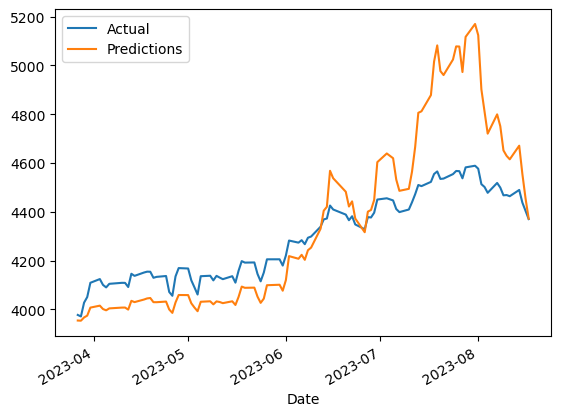

In [266]:
sp500_test['Close'].plot(kind = 'line')
sp500_test['Preds'].plot(kind = 'line')
plt.legend(['Actual', 'Predictions'])
plt.show()

The predictions trend seems to accurately predicting the actual data.

In [267]:
sp500.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-17 00:00:00-04:00,4280.399902,4302.180176,4253.080078,4274.040039,3885030000,1,4289.620117,-15.580078,4272.760059,1.279980,3980.889181,293.150859,4351.478076,-77.438037,3525.995308,748.044731,4283.740234
2022-08-18 00:00:00-04:00,4273.129883,4292.529785,4261.979980,4283.740234,3340330000,0,4278.890137,4.850098,4288.054102,-4.313867,3986.055684,297.684550,4350.846357,-67.106123,3527.381528,756.358707,4228.479980
2022-08-19 00:00:00-04:00,4266.310059,4266.310059,4218.700195,4228.479980,3761340000,0,4256.110107,-27.630127,4277.720117,-49.240137,3990.839018,237.640963,4349.842158,-121.362178,3528.695968,699.784013,4137.990234
2022-08-22 00:00:00-04:00,4195.080078,4195.080078,4129.859863,4137.990234,3907430000,0,4183.235107,-45.244873,4245.890137,-107.899902,3993.493355,144.496879,4348.449199,-210.458965,3529.932828,608.057406,4128.729980
2022-08-23 00:00:00-04:00,4133.089844,4159.770020,4124.029785,4128.729980,3823520000,1,4133.360107,-4.630127,4210.596094,-81.866113,3994.674854,134.055127,4346.979359,-218.249379,3531.160038,597.569942,4140.770020


In [268]:
# scaling sp500 dataframe by standardisation

m = sp500.mean()
std = sp500.std(ddof = 1)
sp500_scaled = (sp500 - m) / std
sp500_scaled

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-17 00:00:00-04:00,0.875084,0.878077,0.848118,0.843337,-0.392586,1.055089,0.913627,-0.681091,0.858097,0.007099,-0.255048,1.592350,2.084570,-0.164338,-1.627213,2.018557,0.880744
2022-08-18 00:00:00-04:00,0.844676,0.836633,0.884299,0.883784,-1.074773,-0.944027,0.868651,0.204674,0.923095,-0.108538,-0.219535,1.622511,2.079403,-0.132064,-1.612037,2.066385,0.650705
2022-08-19 00:00:00-04:00,0.816151,0.724031,0.708355,0.653365,-0.547497,-0.944027,0.773164,-1.203530,0.879177,-1.037260,-0.186655,1.223065,2.071189,-0.301544,-1.597646,1.740922,0.274012
2022-08-22 00:00:00-04:00,0.518220,0.418129,0.347194,0.276049,-0.364532,-0.944027,0.467696,-1.967231,0.743902,-2.249882,-0.168410,0.603415,2.059796,-0.579856,-1.584105,1.213237,0.235463
2022-08-23 00:00:00-04:00,0.258936,0.266488,0.323493,0.237436,-0.469622,1.055089,0.258636,-0.206348,0.593906,-1.711708,-0.160289,0.533950,2.047774,-0.604190,-1.570669,1.152905,0.285584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-11 00:00:00-04:00,1.587349,1.625545,1.624180,1.635623,-0.557578,1.055089,1.654798,-0.109231,1.754495,-0.425199,2.585396,0.107359,-0.234363,1.314818,1.770749,1.326153,1.738202
2023-08-14 00:00:00-04:00,1.618468,1.686098,1.662637,1.742661,-0.378334,-0.944027,1.698580,0.550875,1.730083,0.224203,2.623311,0.241439,-0.228063,1.392599,1.787902,1.464817,1.522317
2023-08-15 00:00:00-04:00,1.705217,1.636883,1.576250,1.526419,-0.458688,-0.944027,1.643690,-1.129827,1.677793,-0.593511,2.650784,-0.130156,-0.223722,1.228945,1.805318,1.157323,1.382738


In [269]:
predictors = ['MR2', 'MR5', 'MRD2', 'MRD5'] 

X = sp500_scaled[predictors]
y = sp500_scaled[['Tomorrow']]
X_train_scaled = X[:-100] 
X_test_scaled = X[-100:]
y_train_scaled = y[:-100]
y_test_scaled = y[-100:]

In [270]:
# defining and fitting model to test data
regressor = SVR(kernel = 'poly')
regressor.fit(X_train_scaled, y_train_scaled)

/Users/cm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='poly')

In [271]:
y_pred_scaled = regressor.predict(X_test_scaled)

/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_6573/222784252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_scaled_test['Preds'] = y_pred_scaled


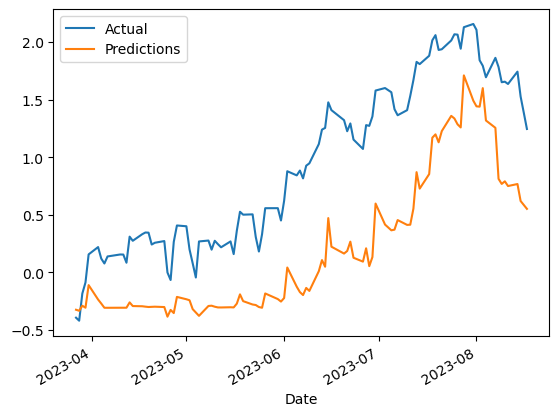

In [272]:
sp500_scaled_test= sp500_scaled[-100:]
sp500_scaled_test['Preds'] = y_pred_scaled

sp500_scaled_test['Close'].plot(kind = 'line')
sp500_scaled_test['Preds'].plot(kind = 'line')
plt.legend(['Actual', 'Predictions'])
plt.show()

Again the prediction seems to follow to trend really well but not the actual value. Using less predictors from MRD turns out to be a worst predictions

# Trying max-min scaling

Here we use max-min scaling instead of standardised scaling. Although this is not recommended for stock price forecasting as there is no theoretical max value of a stock price. But here we will experiment with it. 

On top of changing the scaling methodology, we also tune the SVR model by setting `degree = 2`, `gamma = 1e-2`, and `epsilon = 1e3`. 

In [284]:
sp500.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-17 00:00:00-04:00,4280.399902,4302.180176,4253.080078,4274.040039,3885030000,1,4289.620117,-15.580078,4272.760059,1.279980,3980.889181,293.150859,4351.478076,-77.438037,3525.995308,748.044731,4283.740234
2022-08-18 00:00:00-04:00,4273.129883,4292.529785,4261.979980,4283.740234,3340330000,0,4278.890137,4.850098,4288.054102,-4.313867,3986.055684,297.684550,4350.846357,-67.106123,3527.381528,756.358707,4228.479980
2022-08-19 00:00:00-04:00,4266.310059,4266.310059,4218.700195,4228.479980,3761340000,0,4256.110107,-27.630127,4277.720117,-49.240137,3990.839018,237.640963,4349.842158,-121.362178,3528.695968,699.784013,4137.990234
2022-08-22 00:00:00-04:00,4195.080078,4195.080078,4129.859863,4137.990234,3907430000,0,4183.235107,-45.244873,4245.890137,-107.899902,3993.493355,144.496879,4348.449199,-210.458965,3529.932828,608.057406,4128.729980
2022-08-23 00:00:00-04:00,4133.089844,4159.770020,4124.029785,4128.729980,3823520000,1,4133.360107,-4.630127,4210.596094,-81.866113,3994.674854,134.055127,4346.979359,-218.249379,3531.160038,597.569942,4140.770020


In [285]:
# scaling sp500 using max-min scaling
m = sp500.min()
rg = sp500.max() - m
sp500_scaled = (sp500 - m) / rg
sp500_scaled.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-17 00:00:00-04:00,0.705109,0.694723,0.704076,0.688793,0.284862,1.0,0.704810,0.380162,0.691282,0.450803,0.271370,0.993533,1.000000,0.505784,0.000000,0.974866,0.698379
2022-08-18 00:00:00-04:00,0.698364,0.685060,0.712304,0.698379,0.213639,0.0,0.694109,0.486149,0.707144,0.427706,0.280140,1.000000,0.998384,0.514150,0.004379,0.985872,0.643770
2022-08-19 00:00:00-04:00,0.692037,0.658807,0.672288,0.643770,0.268688,0.0,0.671389,0.317649,0.696426,0.242206,0.288259,0.914350,0.995816,0.470219,0.008531,0.910980,0.554347
2022-08-22 00:00:00-04:00,0.625955,0.587486,0.590147,0.554347,0.287791,0.0,0.598708,0.226267,0.663414,0.000000,0.292765,0.781483,0.992254,0.398078,0.012439,0.789553,0.545196
2022-08-23 00:00:00-04:00,0.568444,0.552131,0.584757,0.545196,0.276819,1.0,0.548965,0.436968,0.626808,0.107493,0.294770,0.766588,0.988495,0.391771,0.016315,0.775670,0.557094


In [286]:
# using the same predictors 
predictors

['MR2', 'MR5', 'MRD2', 'MRD5']

In [287]:
# setting up up training and testing data sets
X = sp500_scaled[predictors]
y = sp500_scaled[['Tomorrow']]
X_train_scaled = X[:-100] 
X_test_scaled = X[-100:]
y_train_scaled = y[:-100]
y_test_scaled = y[-100:]

In [288]:
# setting up model 
regressor = SVR(kernel = 'poly', degree = 2, gamma = 1e2, epsilon = 1e-3)
regressor.fit(X_train_scaled, y_train_scaled)

/Users/cm/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(degree=2, epsilon=0.001, gamma=100.0, kernel='poly')

In [289]:
# computing predictions
y_pred_scaled = regressor.predict(X_test_scaled)

/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_6573/4149358986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_scaled_test['Preds'] = y_pred_scaled


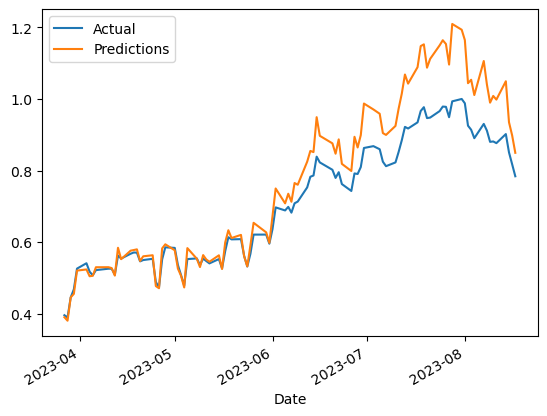

In [297]:
# plotting the predictions with comparison with the actual data
sp500_scaled_test= sp500_scaled[-100:]
sp500_scaled_test['Preds'] = y_pred_scaled

sp500_scaled_test['Close'].plot(kind = 'line')
sp500_scaled_test['Preds'].plot(kind = 'line')
plt.legend(['Actual', 'Predictions'])
plt.show()

## Scaling the result back to normal.

In [299]:
# scaling the value back 
sp500_rescaled = sp500_scaled_test[['Close', 'Preds']]
sp500_rescaled.head()
sp500_rescaled

,Close,Preds
Date,,
2023-03-27 00:00:00-04:00,0.395778,0.390261
2023-03-28 00:00:00-04:00,0.389592,0.380473
2023-03-29 00:00:00-04:00,0.445466,0.445614
2023-03-30 00:00:00-04:00,0.468214,0.455389
2023-03-31 00:00:00-04:00,0.526005,0.520455
...,...,...
2023-08-11 00:00:00-04:00,0.876562,0.998224
2023-08-14 00:00:00-04:00,0.901930,1.049513
2023-08-15 00:00:00-04:00,0.850681,0.934944


In [300]:
# rescaling sp500_rescaled to have normal unscaled value
sp500_rescaled = (sp500_rescaled * rg['Close']) + m['Close']
sp500_rescaled.head()


,Close,Preds
Date,,
2023-03-27 00:00:00-04:00,3977.530029,3971.946585
2023-03-28 00:00:00-04:00,3971.270020,3962.041729
2023-03-29 00:00:00-04:00,4027.810059,4027.960669
2023-03-30 00:00:00-04:00,4050.830078,4037.852212
2023-03-31 00:00:00-04:00,4109.310059,4103.693900


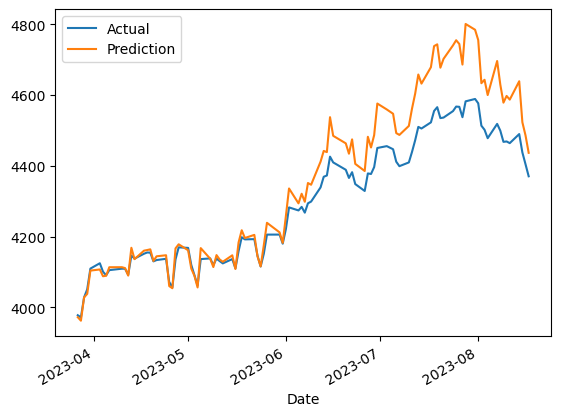

In [303]:
sp500_rescaled.plot(kind = 'line')
plt.legend(['Actual', 'Prediction'])
plt.show()